In [20]:
!git status

On branch anomaly_detection
Your branch is up to date with 'origin/anomaly_detection'.

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../../README.md
	modified:   .ipynb_checkpoints/Auto-Encoders-v1-checkpoint.ipynb
	deleted:    .ipynb_checkpoints/Isolation_Forest-checkpoint.ipynb
	modified:   Auto-Encoders-v1.ipynb
	deleted:    Isolation_Forest.ipynb
	deleted:    Train-Evaluations-Loops-Copy1.ipynb
	modified:   Train-Evaluations-Loops.ipynb
	modified:   autoencoder_best_weights.tf/keras_metadata.pb
	modified:   autoencoder_best_weights.tf/saved_model.pb
	modified:   autoencoder_best_weights.tf/variables/variables.data-00000-of-00001
	modified:   autoencoder_best_weights.tf/variables/variables.index
	modified:   data-exploration.ipynb
	modified:   data_preprocessing.ipynb
	modified:   ../src/data/__init__.py
	modified:   ../src/data/features.py
	modified

#  Imports

In [1]:
%%bash
pip install wheel pandas matplotlib plotly wandb autohash 
export WANDB_NOTEBOOK_NAME='data-exploration-new'

#### Init W&B 

In [2]:
import wandb
wandb.init(project="anomaly-detection-idc")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: adielm (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
2021-09-19 11:51:30.269891: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-09-19 11:51:30.269922: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [1]:
import sys
import torch
import ipaddress
import pandas as pd
import seaborn as sns
import plotly.express as px
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import sys
module_path = sys.path.append('/home/ubuntu/nabu/anomaly_detection/src')
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
from data import *
# from helpers import *

# Data Preprocessing

In [7]:
DATA = Path('../data')
ALL_DATA_PATH = DATA / 'global_sh2.json'
MALICIOUS_PATH = DATA / 'global_sh23.08.json'
DATASET_PATH = DATA / 'dataset_.csv'

In [8]:
df_mal = (load_data(MALICIOUS_PATH)
          .pipe(drop_columns, cols_names=['protocol', 'data', 'public_proxy', 'tor', 'raw_data'])
          .pipe(optimize_memory))
df_mal

parsing raws:   0%|          | 0/1075 [00:00<?, ?it/s]

memory usage reduced from 534337 to 234101


,_id,session_id,sensor_id,port,ip,ts,country,packet_size,identify
0,60e335eee9809b72a5b0da67,2bac0c20-9138-454e-815d-b316d40f4444,9c5a6d9180556d6893c7fbe7f8a12644c7565ea5,3389,52.191.186.39,2021-07-05 16:40:14.495000+00:00,US,42,True
1,60e33610e9809b72a5b0db24,2bac0c20-9138-454e-815d-b316d40f4444,9c5a6d9180556d6893c7fbe7f8a12644c7565ea5,3389,52.191.186.39,2021-07-05 16:40:48.685000+00:00,US,9,True
2,60e33629e9809b72a5b0dba5,13d9ec0f-d429-458b-8fc0-7aa4be53b978,c62f83d026c1fd87ae0c99c15172b0d619669b85,3389,52.191.186.39,2021-07-05 16:41:13.898000+00:00,US,37,True
3,60e3362be9809b72a5b0dbaf,42602f83-41dc-448d-9f8b-71faaf90c4dc,bf35d4c4fc8b8209d93fc720dbe58d9146aa4bc8,3389,52.191.186.39,2021-07-05 16:41:15.504000+00:00,US,42,True
4,60e33635e9809b72a5b0dbe8,2bac0c20-9138-454e-815d-b316d40f4444,9c5a6d9180556d6893c7fbe7f8a12644c7565ea5,3389,52.191.186.39,2021-07-05 16:41:25.510000+00:00,US,37,True
...,...,...,...,...,...,...,...,...,...
1070,6107d420f7368742c4716c4d,b9a14b07-3d02-408c-b780-880942ee6c64,9967ef6ba9f9aa5b0625e8b34b8c31dfd7b6dc50,3389,194.26.29.28,2021-08-02 11:16:48.618000+00:00,RU,47,True
1071,6107d428f7368742c4716c56,b9a14b07-3d02-408c-b780-880942ee6c64,9967ef6ba9f9aa5b0625e8b34b8c31dfd7b6dc50,3389,194.26.29.28,2021-08-02 11:16:56.221000+00:00,RU,9,True
1072,6107d42bf7368742c4716c59,b9a14b07-3d02-408c-b780-880942ee6c64,9967ef6ba9f9aa5b0625e8b34b8c31dfd7b6dc50,3389,194.26.29.28,2021-08-02 11:16:59.460000+00:00,RU,37,True
1073,6107ed4ff7368742c4718964,5609ec7b-3a5d-46e8-bc94-16504828400c,64fb455e0f428b9b5a28d35ab601793cc61461d5,3389,3.231.236.53,2021-08-02 13:04:15.761000+00:00,US,9,True


In [15]:
def port_to_dummy_bits(df: pd.DataFrame) -> pd.DataFrame:
    df_tmp = df.apply(lambda i: pd.Series([int(b) for b in format(int(i['port']), '016b')], dtype='int8'), axis=1)
    df_tmp.columns = df_tmp.columns.map(lambda bit_idx: f'port_bit_{bit_idx}')
    return pd.concat([df, df_tmp], axis=1)

In [9]:
df_all = (load_data(ALL_DATA_PATH))

parsing raws:   0%|          | 0/1648904 [00:00<?, ?it/s]

In [11]:
df_all.columns

Index(['_id', 'session_id', 'sensor_id', 'protocol', 'port', 'ip', 'data',
       'ts', 'country', 'public_proxy', 'tor', 'packet_size', 'raw_data'],
      dtype='object')

In [19]:
df_all.nunique()

_id             1648904
session_id      1604008
sensor_id           867
protocol              1
port                 10
ip                 6517
data             141706
ts              1644113
country             107
public_proxy          2
tor                   2
packet_size         339
raw_data         141706
dtype: int64

In [14]:
df_all.dtypes


_id              object
session_id       object
sensor_id        object
protocol         object
port              int64
ip               object
data             object
ts               object
country          object
public_proxy       bool
tor                bool
packet_size     float64
raw_data         object
dtype: object

In [9]:
df_all = (load_data(ALL_DATA_PATH)
          .pipe(drop_columns, cols_names=['protocol', 'data', 'public_proxy', 'tor', 'raw_data'])
          .pipe(optimize_memory)
          .pipe(add_labels, malicious_ids=df_mal._id.unique())
          .pipe(handle_missing, missing={'country': 'other', 'packet_size': 0})
          .pipe(create_aggregatoins)
          .pipe(ipv4_to_dummy_bits))
df_all

parsing raws:   0%|          | 0/1648904 [00:00<?, ?it/s]

memory usage reduced from 819430419 to 335577376


,_id,session_id,sensor_id,port,ip,ts,country,packet_size,identify,accum_packet_size,...,ip_bit_22,ip_bit_23,ip_bit_24,ip_bit_25,ip_bit_26,ip_bit_27,ip_bit_28,ip_bit_29,ip_bit_30,ip_bit_31
0,60e3347be9809b72a5b0d334,ec892c1a-e1cc-45ea-8040-ced7bef29d87,44f231a130a17ef5d5184dcbaf6f762fbb10bc01,1433,111.122.172.149,2021-07-05 16:34:03.312000+00:00,CN,52.0,False,52.0,...,0,0,1,0,0,1,0,1,0,1
1,60e3347be9809b72a5b0d335,45827df4-fc6c-42c3-b8a8-07ca7c39fee6,0d6947688ba52aa0a47696825134b2b1c30487a3,3389,59.125.225.176,2021-07-05 16:34:03.367000+00:00,TW,43.0,False,43.0,...,0,1,1,0,1,1,0,0,0,0
2,60e3347be9809b72a5b0d336,d8b6b5bf-fead-483c-b205-b1ba082661c8,0d6947688ba52aa0a47696825134b2b1c30487a3,3389,45.146.167.35,2021-07-05 16:34:03.423000+00:00,RU,43.0,False,43.0,...,1,1,0,0,1,0,0,0,1,1
3,60e3347be9809b72a5b0d337,01c99580-ca72-43a0-9b8e-27c2560543a0,0d6947688ba52aa0a47696825134b2b1c30487a3,3389,185.219.52.83,2021-07-05 16:34:03.478000+00:00,PL,43.0,False,43.0,...,0,0,0,1,0,1,0,0,1,1
4,60e3347be9809b72a5b0d338,bc2b1527-6edf-48f1-9b9a-3d5129c698c7,0d6947688ba52aa0a47696825134b2b1c30487a3,3389,62.94.72.8,2021-07-05 16:34:03.536000+00:00,IT,43.0,False,43.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648899,610804a2f7368742c471a445,3a551a24-3f5a-4186-8663-aecaa760e941,6c85b2ec679ff3a241d3f75f2b2271d84f404061,3389,143.198.184.62,2021-08-02 14:43:46.687000+00:00,US,43.0,False,43.0,...,0,0,0,0,1,1,1,1,1,0
1648900,610804a3f7368742c471a446,cac661ef-7bfd-4b1f-af38-0415bea9002c,1524a8caae1ac9ba10d1bf8c1dbe0ab9a756e71f,3389,143.198.184.62,2021-08-02 14:43:47.742000+00:00,US,43.0,False,43.0,...,0,0,0,0,1,1,1,1,1,0
1648901,610804a3f7368742c471a447,4f1988be-805f-4c1b-a118-2e547690ec38,27b358140e1b4775e8d111a2dce1c1a511ab1a25,3389,143.198.184.62,2021-08-02 14:43:47.789000+00:00,US,43.0,False,43.0,...,0,0,0,0,1,1,1,1,1,0
1648902,610804a3f7368742c471a448,3f11ab2e-796f-4fe2-9141-0f3516643a52,61dad96a38af688703c732e81548d818ae361846,3389,143.198.184.62,2021-08-02 14:43:47.855000+00:00,US,43.0,False,43.0,...,0,0,0,0,1,1,1,1,1,0


In [12]:
# write prepared dataset clean
df_all[~df_all.identify].to_csv(DATA / 'dataset_ready_clean.csv', index=False)

# write prepared dataset malicious
df_all[df_all.identify].to_csv(DATA / 'dataset_ready_mal.csv', index=False)

# Exploratory Analysis

In [6]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648904 entries, 0 to 1648903
Data columns (total 43 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   _id                1648904 non-null  object             
 1   session_id         1648904 non-null  object             
 2   sensor_id          1648904 non-null  category           
 3   port               1648904 non-null  int64              
 4   ip                 1648904 non-null  category           
 5   ts                 1648904 non-null  datetime64[ns, UTC]
 6   country            1648904 non-null  category           
 7   packet_size        1648904 non-null  float64            
 8   identify           1648904 non-null  bool               
 9   accum_packet_size  1648904 non-null  float64            
 10  accum_count_by_ip  1648904 non-null  int64              
 11  ip_bit_0           1648904 non-null  int8               
 12  ip_bit_1      

In [ ]:
print('contains null values:')
[col_name for col_name, contains_null in df_all.isnull().any().items() if contains_null]

In [ ]:
df_all.describe()

In [41]:
print('Clean/Malicious dist:')
print(df_all.identify.value_counts())
print()
print(df_all.identify.value_counts(normalize=True))

Clean/Malicious dist:
False    1647829
True        1075
Name: identify, dtype: int64

False    0.999348
True     0.000652
Name: identify, dtype: float64


In [62]:
df_all.ip.value_counts().nlargest(20)

143.198.184.62     222827
192.3.154.45        64046
111.122.172.149     58578
3.231.236.53        49631
217.160.191.146     44771
52.66.218.20        39561
52.193.224.37       34872
107.175.240.107     33721
84.242.35.58        32766
164.52.24.165       23280
175.101.6.210       22876
92.126.152.50       19239
49.248.148.122      17893
91.191.209.30       17202
150.95.81.104       16370
162.142.125.54      14713
162.142.125.56      14084
162.142.125.38      13898
162.142.125.55      13881
162.142.125.40      13867
Name: ip, dtype: int64

In [64]:
df_all[df_all.identify].ip.value_counts().nlargest(14)

3.231.236.53       1000
52.191.186.39        15
80.82.70.228          9
218.94.34.54          9
211.204.191.6         9
176.106.243.230       6
87.251.70.43          6
52.130.64.254         3
45.129.136.17         3
194.30.93.42          3
194.26.29.28          3
219.240.18.62         3
178.88.175.197        3
221.179.249.226       3
Name: ip, dtype: int64

<Figure size 720x1080 with 0 Axes>

num. of unique country (all): 107


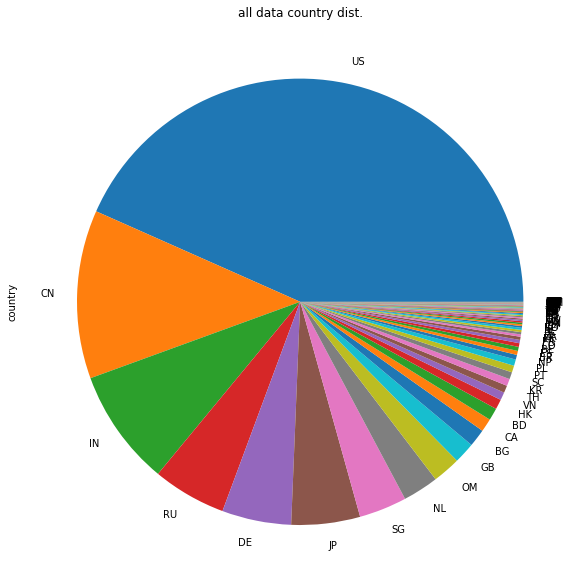

In [85]:
plt.figure(figsize=(10, 15))
_ = df_all.country.value_counts().plot.pie(title='all data country dist.')
print('num. of unique country (all):', (df_all.country.value_counts()>0).sum())

In [ ]:
df_all.country.value_counts(normalize=True)

<Figure size 720x1080 with 0 Axes>

num. of unique country (malicious): 8


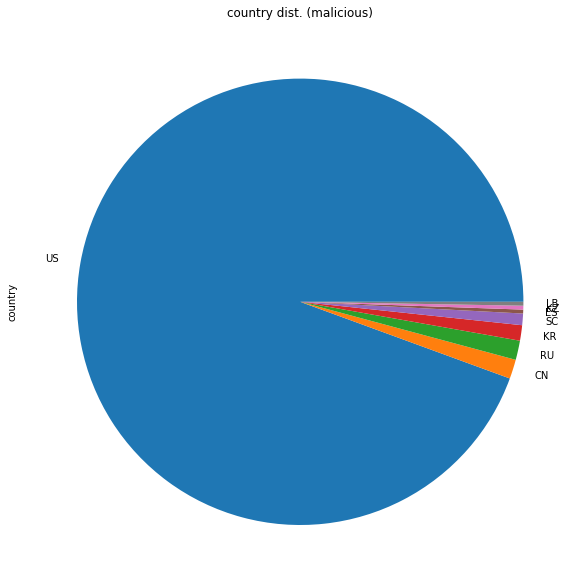

In [83]:
plt.figure(figsize=(10, 15))
_ = df_all[df_all.identify].country.value_counts().plot.pie(title='country dist. (malicious)')
print('num. of unique country (malicious):', (df_all[df_all.identify].country.value_counts()>0).sum())

In [86]:
country_counts = df_all[df_all.identify].country.value_counts()
country_counts

US    1015
CN      15
RU      15
KR      12
SC       9
      ... 
GE       0
GB       0
FR       0
FI       0
ZW       0
Name: country, Length: 107, dtype: int64

In [65]:
df_all.tor.value_counts()

False    1623004
True       25900
Name: tor, dtype: int64

In [66]:
df_all.public_proxy.value_counts()

False    1623004
True       25900
Name: public_proxy, dtype: int64

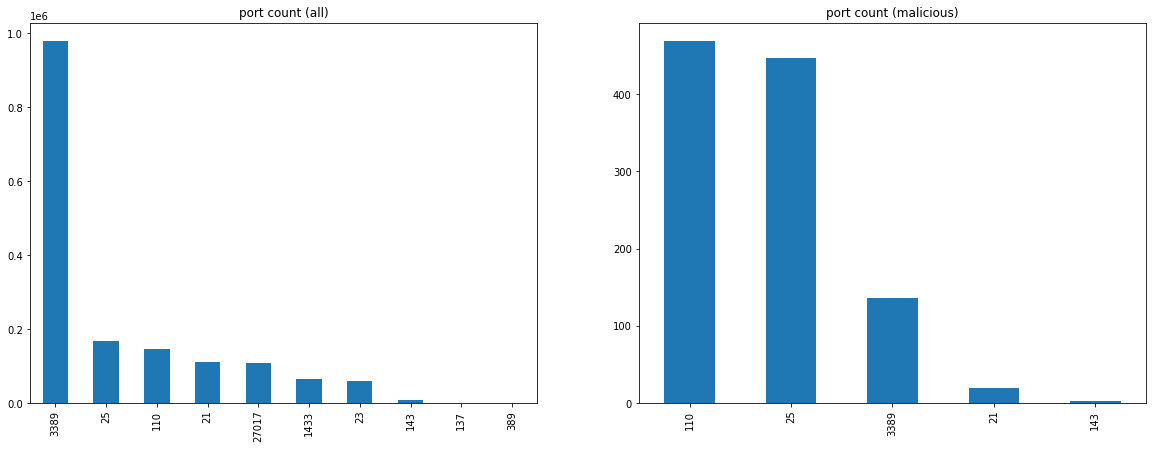

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
_ = df_all.port.value_counts().plot.bar(title='port count (all)', ax=axes[0])
_ = df_all[df_all.identify].port.value_counts().plot.bar(title='port count (malicious)', ax=axes[1])

In [79]:
print('is tor and public_category are always equals:',(df_all.tor == df_all.public_proxy).all())

is tor and public_category are always equals: True


In [81]:
sensor_id_mal = (df_all[df_all.identify].sensor_id.value_counts()>0).sum()
print('num. of unique sensor_id (malicious):', sensor_id_mal)

num. of unique sensor_id (malicious): 108


In [104]:
print('all data:')
print(f'number of recoreds: {len(df_all)}')
print(f'number of unique data: {df_all.data.nunique()}')
print(f'number of unique sensors: {df_all.sensor_id.nunique()}')
print(f'number of unique IPs: {df_all.ip.nunique()}')
print(f'number of unique countries: {df_all.country.nunique()}')
print(f'number of unique protocols: {[(k, v) for k, v in df_all.protocol.value_counts().items()]}')

all data:
number of recoreds: 1648904
number of unique data: 141706
number of unique sensors: 867
number of unique IPs: 6517
number of unique countries: 107
number of unique protocols: [('tcp', 1648904)]


In [103]:
print('malicious data:')
print(f'number of recoreds: {len(df_mal)}')
print(f'number of unique data: {df_mal.data.nunique()}')
print(f'number of unique sensors: {df_mal.sensor_id.nunique()}')
print(f'number of unique IPs: {df_mal.ip.nunique()}')
print(f'number of unique countries: {df_mal.country.nunique()}')
print(f'number of unique protocols: {[(k, v) for k, v in df_mal.protocol.value_counts().items()]}')

malicious data:
number of recoreds: 1075
number of unique data: 6
number of unique sensors: 108
number of unique IPs: 14
number of unique countries: 8
number of unique protocols: [('tcp', 1075)]


In [114]:
df_all['accum_packet_size'] = df_all.sort_values(by='ts').groupby('session_id')['packet_size'].cumsum()

In [126]:
df_all['accum_count_by_ip'] = 1
df_all['accum_count_by_ip'] = df_all.sort_values(by='ts').groupby('ip')['accum_count_by_ip'].cumsum()

In [127]:
df_all

,_id,session_id,sensor_id,protocol,port,ip,data,ts,country,public_proxy,tor,packet_size,raw_data,identify,accum_packet_size,accum_count_by_ip
0,60e3347be9809b72a5b0d334,ec892c1a-e1cc-45ea-8040-ced7bef29d87,44f231a130a17ef5d5184dcbaf6f762fbb10bc01,tcp,1433,111.122.172.149,EgEANAAAAAAAABUABgEAGwABAgAcAAwDACgABP8IAAFVAA...,2021-07-05 16:34:03.312000+00:00,CN,False,False,52.0,EgEANAAAAAAAABUABgEAGwABAgAcAAwDACgABP8IAAFVAA...,False,52.0,1
1,60e3347be9809b72a5b0d335,45827df4-fc6c-42c3-b8a8-07ca7c39fee6,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,59.125.225.176,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05 16:34:03.367000+00:00,TW,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,1
2,60e3347be9809b72a5b0d336,d8b6b5bf-fead-483c-b205-b1ba082661c8,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,45.146.167.35,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05 16:34:03.423000+00:00,RU,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,1
3,60e3347be9809b72a5b0d337,01c99580-ca72-43a0-9b8e-27c2560543a0,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,185.219.52.83,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05 16:34:03.478000+00:00,PL,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,1
4,60e3347be9809b72a5b0d338,bc2b1527-6edf-48f1-9b9a-3d5129c698c7,0d6947688ba52aa0a47696825134b2b1c30487a3,tcp,3389,62.94.72.8,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-07-05 16:34:03.536000+00:00,IT,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648899,610804a2f7368742c471a445,3a551a24-3f5a-4186-8663-aecaa760e941,6c85b2ec679ff3a241d3f75f2b2271d84f404061,tcp,3389,143.198.184.62,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-08-02 14:43:46.687000+00:00,US,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,222823
1648900,610804a3f7368742c471a446,cac661ef-7bfd-4b1f-af38-0415bea9002c,1524a8caae1ac9ba10d1bf8c1dbe0ab9a756e71f,tcp,3389,143.198.184.62,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-08-02 14:43:47.742000+00:00,US,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,222824
1648901,610804a3f7368742c471a447,4f1988be-805f-4c1b-a118-2e547690ec38,27b358140e1b4775e8d111a2dce1c1a511ab1a25,tcp,3389,143.198.184.62,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-08-02 14:43:47.789000+00:00,US,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,222825
1648902,610804a3f7368742c471a448,3f11ab2e-796f-4fe2-9141-0f3516643a52,61dad96a38af688703c732e81548d818ae361846,tcp,3389,143.198.184.62,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,2021-08-02 14:43:47.855000+00:00,US,False,False,43.0,AwAAKybgAAAAAABDb29raWU6IG1zdHNoYXNoPWhlbGxvDQ...,False,43.0,222826


In [128]:
df_all.describe()

,port,packet_size,accum_packet_size,accum_count_by_ip
count,1.648904e+06,1.648898e+06,1.648898e+06,1.648904e+06
mean,3.876867e+03,5.637214e+01,6.345362e+01,2.199006e+04
std,6.345158e+03,5.892995e+01,1.929048e+02,4.406579e+04
min,2.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.100000e+02,4.300000e+01,4.300000e+01,4.130000e+02
50%,3.389000e+03,4.300000e+01,4.300000e+01,3.227000e+03
75%,3.389000e+03,4.400000e+01,4.600000e+01,1.951900e+04
max,2.701700e+04,8.191000e+03,2.474100e+04,2.228270e+05


<Figure size 720x504 with 0 Axes>

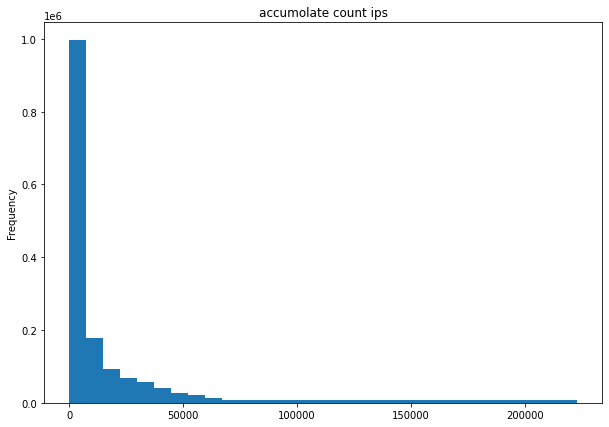

In [140]:
plt.figure(figsize=(10, 7))
_ = df_all.accum_count_by_ip.plot.hist(title='accumolate count ips', bins=30)

In [250]:
df_tmp = df_all.apply(lambda i: pd.Series([int(b) for b in format(int(ipaddress.IPv4Address(i['ip'])), '032b')], dtype='int8'), axis=1)

In [251]:
df_tmp

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0,1,1,0,1,1,1,1,0,1,...,0,0,1,0,0,1,0,1,0,1
1,0,0,1,1,1,0,1,1,0,1,...,0,1,1,0,1,1,0,0,0,0
2,0,0,1,0,1,1,0,1,1,0,...,1,1,0,0,1,0,0,0,1,1
3,1,0,1,1,1,0,0,1,1,1,...,0,0,0,1,0,1,0,0,1,1
4,0,0,1,1,1,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648899,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,0
1648900,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,0
1648901,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,0
1648902,1,0,0,0,1,1,1,1,1,1,...,0,0,0,0,1,1,1,1,1,0


In [ ]:
# sns.pairplot(df_all[['packet_size', 'accum_count_by_ip', 'accum_packet_size']])

In [8]:
df_all[df_all.packet_size != df_all.accum_packet_size]

,_id,session_id,sensor_id,port,ip,ts,country,packet_size,identify,accum_packet_size,...,ip_bit_22,ip_bit_23,ip_bit_24,ip_bit_25,ip_bit_26,ip_bit_27,ip_bit_28,ip_bit_29,ip_bit_30,ip_bit_31
99,60e3348fe9809b72a5b0d397,600de912-1e8f-4742-8fa2-a229a9487eea,c62f83d026c1fd87ae0c99c15172b0d619669b85,3389,218.94.34.54,2021-07-05 16:34:23.783000+00:00,CN,9.0,False,46.0,...,1,0,0,0,1,1,0,1,1,0
106,60e33491e9809b72a5b0d39e,baf786ad-51fb-442e-b25a-0e8bf82850c3,c17594e27a189d2e3bfda7d8e5e413726c2b48d7,3389,218.94.34.54,2021-07-05 16:34:25.220000+00:00,CN,9.0,False,51.0,...,1,0,0,0,1,1,0,1,1,0
205,60e334a4e9809b72a5b0d401,689fb6dd-d512-489f-9482-de9e71cf5557,2c772e712b523c3a90377f854cb7197bea776f0b,389,206.189.111.240,2021-07-05 16:34:44.062000+00:00,NL,18.0,False,36.0,...,1,1,1,1,1,1,0,0,0,0
326,60e334bae9809b72a5b0d47a,689fb6dd-d512-489f-9482-de9e71cf5557,2c772e712b523c3a90377f854cb7197bea776f0b,389,206.189.111.240,2021-07-05 16:35:06.929000+00:00,NL,18.0,False,54.0,...,1,1,1,1,1,1,0,0,0,0
434,60e334d0e9809b72a5b0d4e6,6bbf112c-4f60-4b89-b49d-409e7108623e,212b57841229e16f5384ee2162f2c5d781b0297c,3389,211.204.191.6,2021-07-05 16:35:28.470000+00:00,KR,9.0,False,51.0,...,1,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1648245,6108024cf7368742c471a1b7,26017726-867a-4676-9331-b5ee0b0799aa,0a2f9cf552c93056d54509a4043bc072ef89889c,3389,94.232.43.63,2021-08-02 14:33:48.316000+00:00,RU,46.0,False,93.0,...,1,1,0,0,1,1,1,1,1,1
1648264,6108025ff7368742c471a1ca,80e3d98a-bc48-46c6-ac47-7fba47dea71e,940670f5bafd3e8b7bb877899d4588b08ba08bc8,27017,147.182.236.153,2021-08-02 14:34:07.271000+00:00,US,18.0,False,36.0,...,0,0,1,0,0,1,1,0,0,1
1648266,6108025ff7368742c471a1cc,80e3d98a-bc48-46c6-ac47-7fba47dea71e,940670f5bafd3e8b7bb877899d4588b08ba08bc8,27017,147.182.236.153,2021-08-02 14:34:07.388000+00:00,US,18.0,False,54.0,...,0,0,1,0,0,1,1,0,0,1
1648331,61080297f7368742c471a20d,89cf6bbf-c6fc-450e-9aee-a34aebbc023a,bb8857dbee2e7b9ba70334c8155e56ce8723be73,3389,185.202.1.81,2021-08-02 14:35:03.809000+00:00,RU,46.0,False,93.0,...,0,1,0,1,0,1,0,0,0,1


Text(0.5, 0.98, 'Pair Plot')

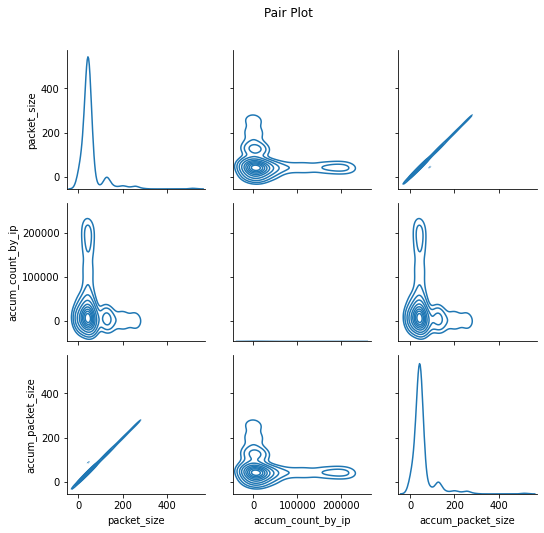

In [11]:
g = sns.PairGrid(df_all[['packet_size', 'accum_count_by_ip', 'accum_packet_size']].sample(100_000, random_state=0))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Befor:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)

In [8]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

In [9]:
pipeline.fit(df_all[['packet_size', 'accum_count_by_ip', 'accum_packet_size']])

Pipeline(steps=[('normalizer', Normalizer()), ('scaler', MinMaxScaler())])

In [10]:
transformed = pipeline.transform(df_all[['packet_size', 'accum_count_by_ip', 'accum_packet_size']])

Text(0.5, 0.98, 'After:')

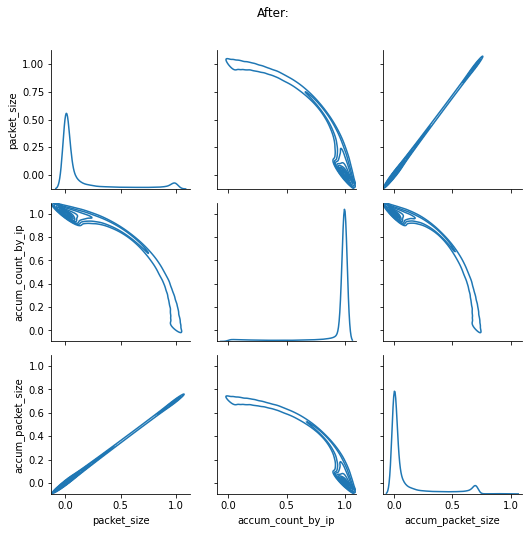

In [13]:
g = sns.PairGrid(pd.DataFrame(transformed, columns=['packet_size', 'accum_count_by_ip', 'accum_packet_size']).sample(100_000, random_state=0))
plt.subplots_adjust(top=0.9)
g.fig.suptitle('After:')
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot)